In [1]:
import re

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [3]:
coords = list()
with open('./input.txt') as f:
    for line in f.read().splitlines():
        # need to parse out the coords from the input
        m = re.match(r'\w+=<(?P<p_x>[\s\-0-9]+),(?P<p_y>[\s\-0-9]+)>.*<(?P<v_x>[\s\-0-9]+),(?P<v_y>[\s\-0-9]+)>', line)
        
        p_x, p_y, v_x, v_y = int(m.group('p_x').strip()), int(m.group('p_y').strip()), int(m.group('v_x').strip()), int(m.group('v_y').strip())
        
        # create a list of the attributes
        coords.append([p_x, p_y, v_x, v_y])

In [4]:
coords[:5]

[[20168, 40187, -2, -4],
 [-39906, -49878, 4, 5],
 [30186, 10170, -3, -1],
 [30150, 50195, -3, -5],
 [50184, 40190, -5, -4]]

In [5]:
class Star(object):
    def __init__(self, p_x, p_y, v_x, v_y):
        self.p_x = p_x
        self.p_y = p_y
        self.v_x = v_x
        self.v_y = v_y

    def increase_sec(self):
        # add to the coords based on velocity
        self.p_x += self.v_x
        self.p_y += self.v_y

    def coord(self):
        # return current location
        return self.p_x, self.p_y


class NightSky(object):
    def __init__(self, stars):
        self.stars = stars

    def increase_sec(self):
        # only possible because the stars have the same function call
        for star in self.stars:
            star.increase_sec()

    def paint_the_sky(self):
        # grab the dimensions to create a dataframe
        index, columns = self._get_sky_dimensions()
        
        # default with nan values
        sky = pd.DataFrame(np.full((len(columns), len(index)), fill_value=np.nan))
        
        # this is for negative indexing. I need to relabel the index and columns so I can 
        # locate the appropriate star
        # also.. flipping the axis so I can read the message haha
        sky.rename(index={i: str(columns[i]) for i in range(len(columns))}, inplace=True)
        sky.columns = [str(i) for i in index]

        for star in self.stars:
            x, y = star.coord()

            sky.loc[str(y), str(x)] = 9

        return sky

    def _get_sky_dimensions(self):
        # based on the min and max x and y values of the stars in the sky
        min_x, min_y, max_x, max_y = 0, 0, 0, 0
        
        for ind, star in enumerate(self.stars):
            # first star gets set on the first iteration
            if not ind:
                min_x, min_y, max_x, max_y = star.p_x, star.p_y, star.p_x, star.p_y

            else:
                if star.p_x < min_x:
                    min_x = star.p_x

                if star.p_y < min_y:
                    min_y = star.p_y

                if star.p_x > max_x:
                    max_x = star.p_x

                if star.p_x > max_y:
                    max_y = star.p_y
                    
        index = list(range(min_x - 25, max_x + 25))
        columns = list(range(min_y - 25, max_y + 25))
        
        return index, columns
    
    def get_star_shape_over_time(self, sec_range=5):
        # determine what the shape will be over a period of time. 
        # since the matrix is initially too big, it will take up too much memory 
        # to draw it out and map it.
        # This helps to figure out the range that the word is likely to be in
        sec, axis, shape = list(), list(), list()
        
        for i in range(sec_range):
            index, columns = self._get_sky_dimensions()
            
            sec.extend([i, i])
            axis.extend(['x', 'y'])
            shape.extend([len(index), len(columns)])
            
            self.increase_sec()
            
        return pd.DataFrame(data={'sec': sec, 'axis': axis, 'shape': shape})

In [6]:
night_sky = NightSky([Star(*star) for star in coords])

Something I found out pretty quickly is that the sky is really big. 
In the examples.. The message matrix was the smallest shape.
So, I need to do a little pre-digging to figure out the second range is with the smallest shapes. 

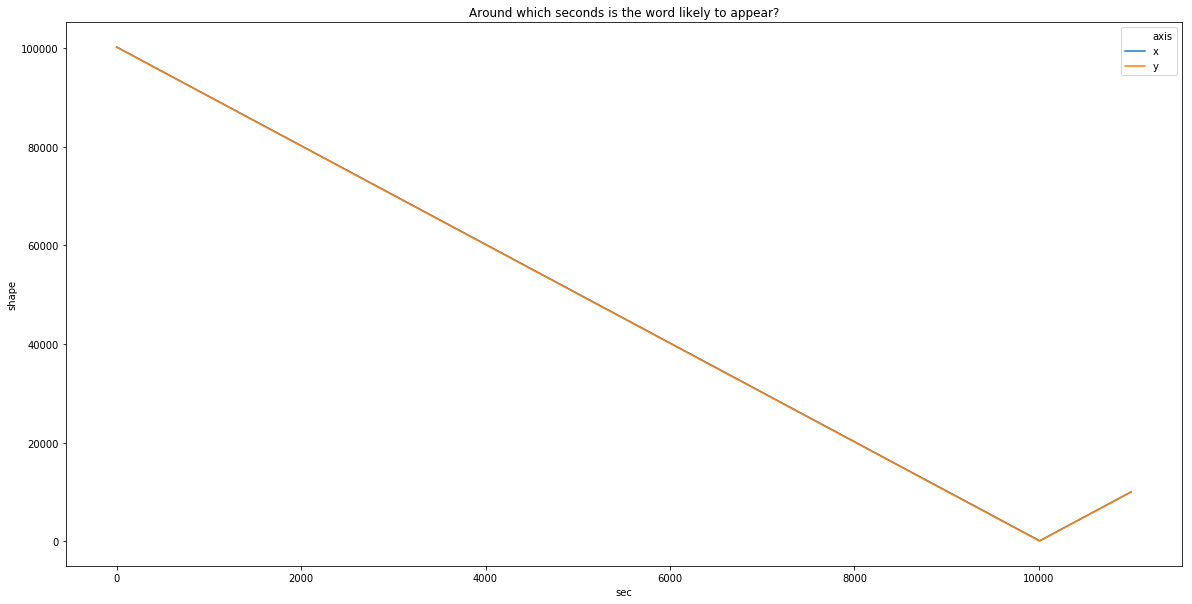

In [7]:
star_shape = night_sky.get_star_shape_over_time(sec_range=11000)

ax = sns.lineplot(
    x="sec", 
    y="shape", 
    hue="axis",
    data=star_shape)

plt.title('Around which seconds is the word likely to appear?')
plt.show();

Now I know where the word is likely to appear! 
So, I can start over within that range and plot it out. 

/Users/taylorperkins/.virtualenvs/code_of_advent/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


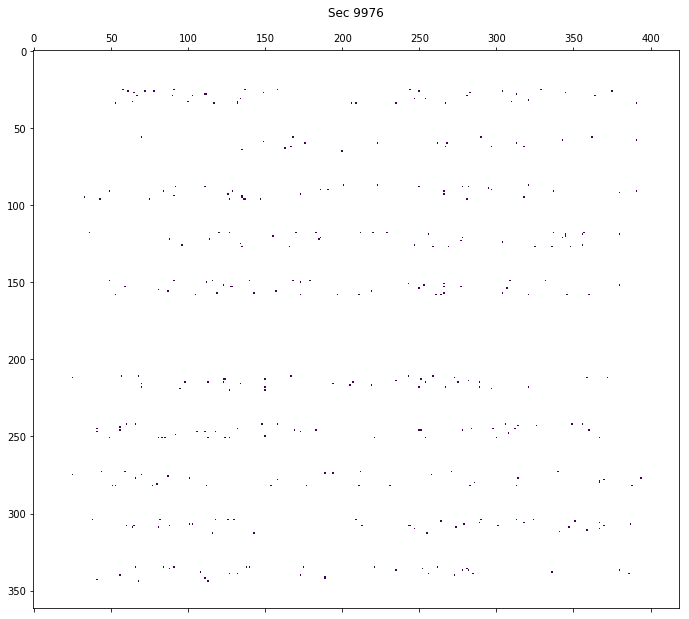

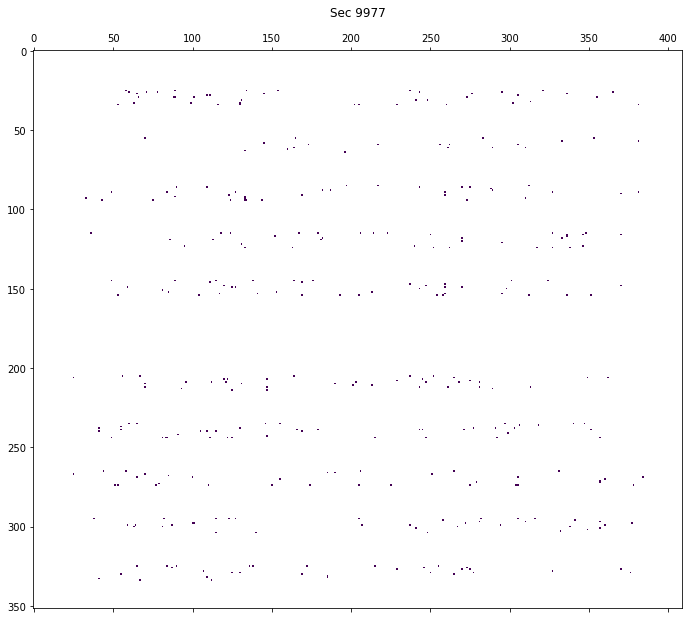

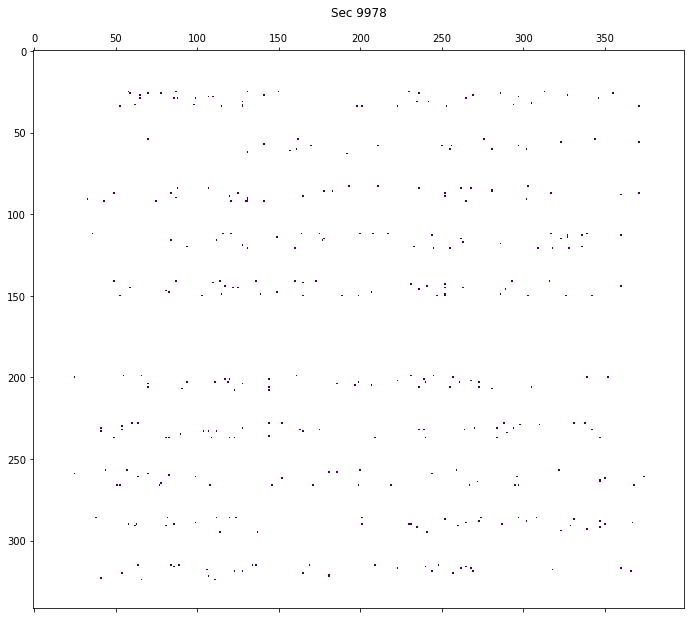

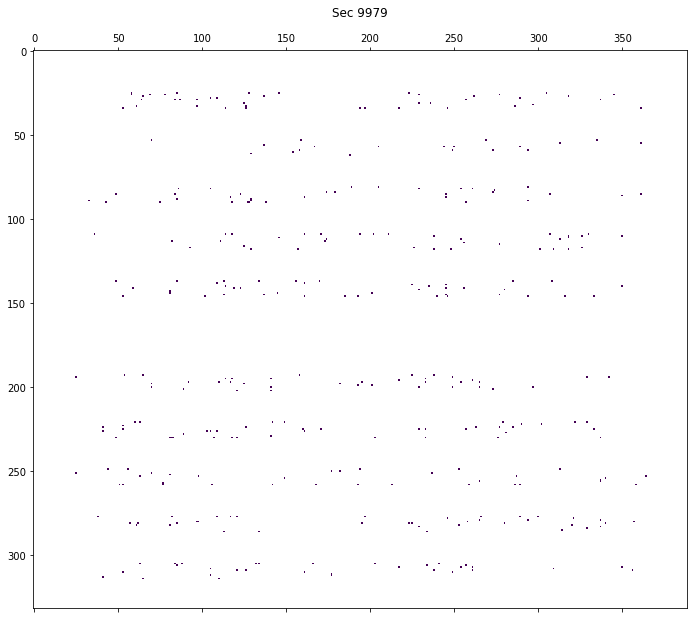

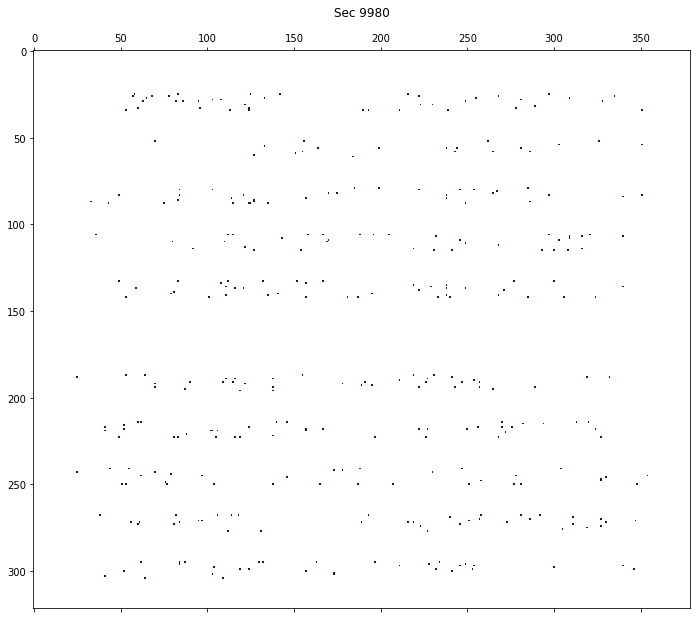

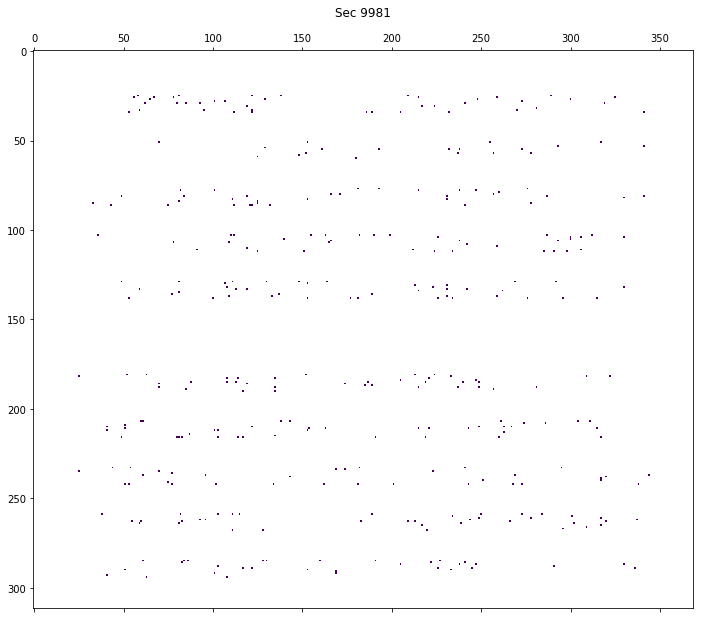

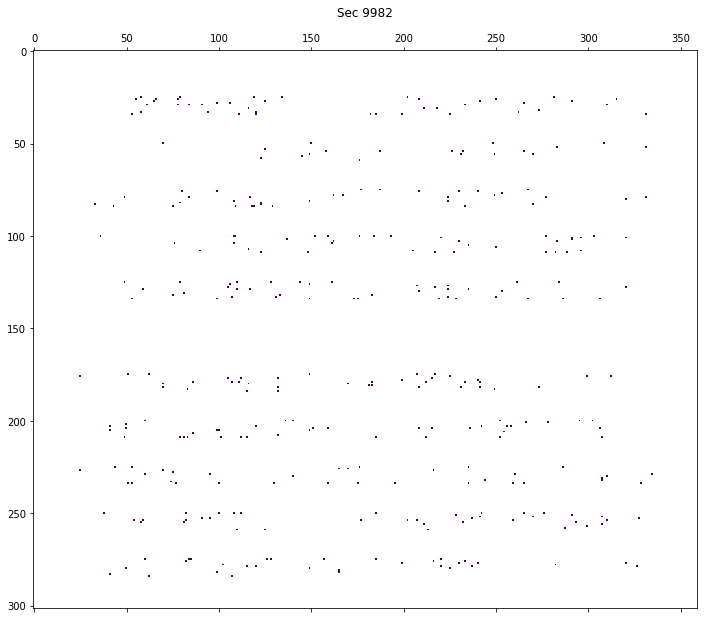

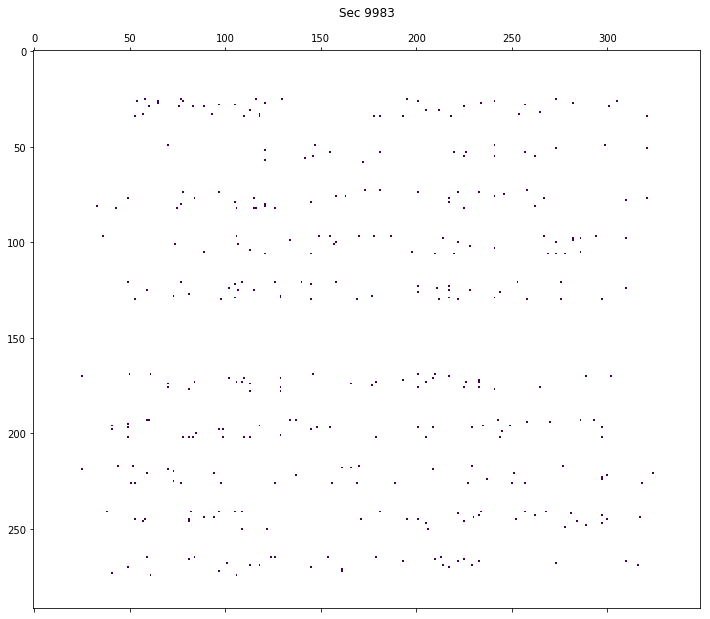

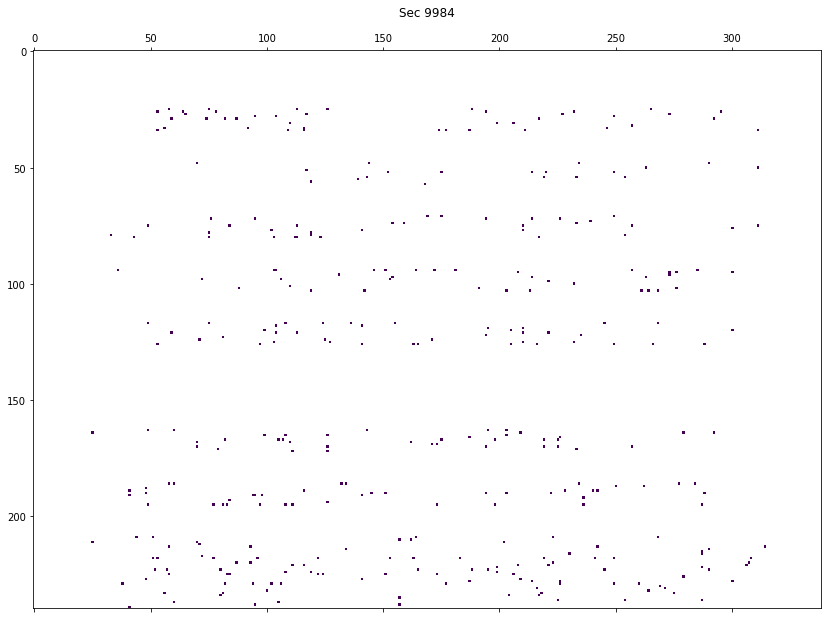

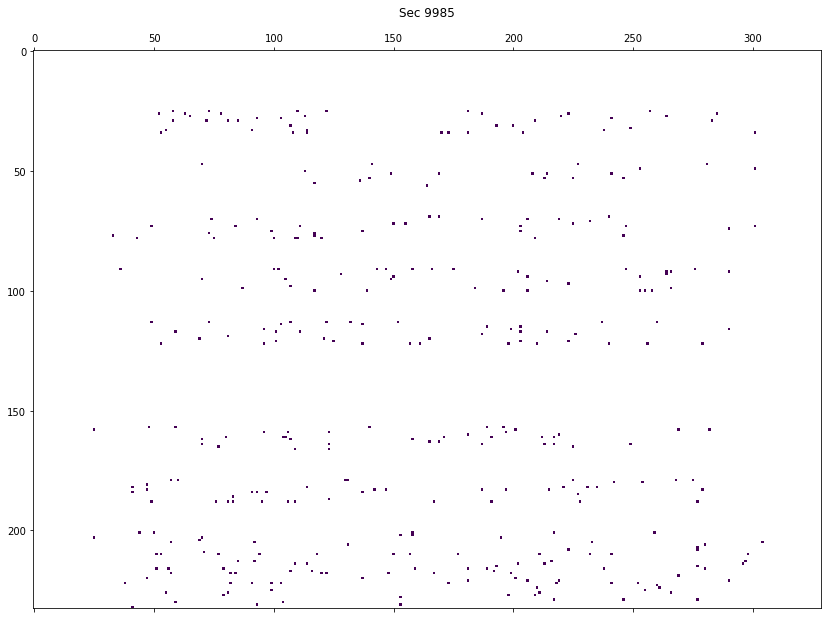

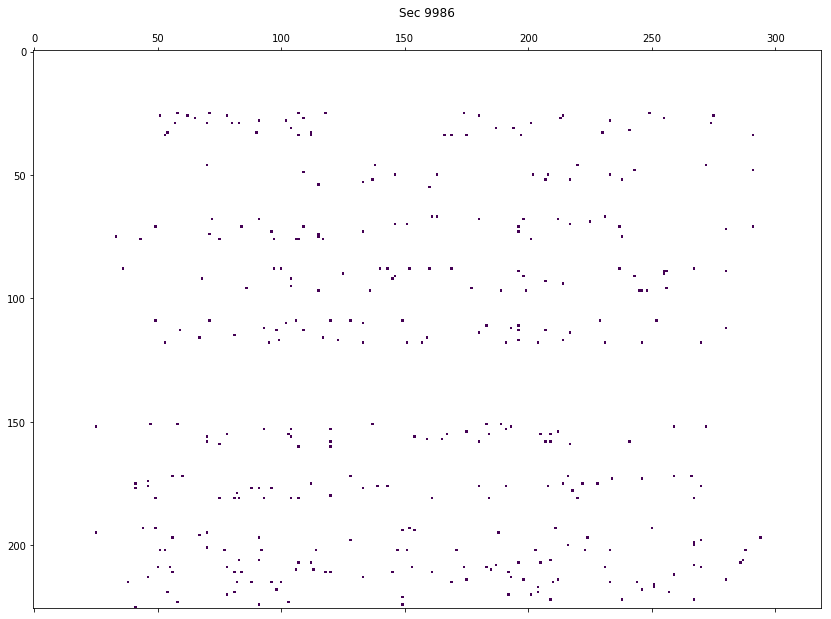

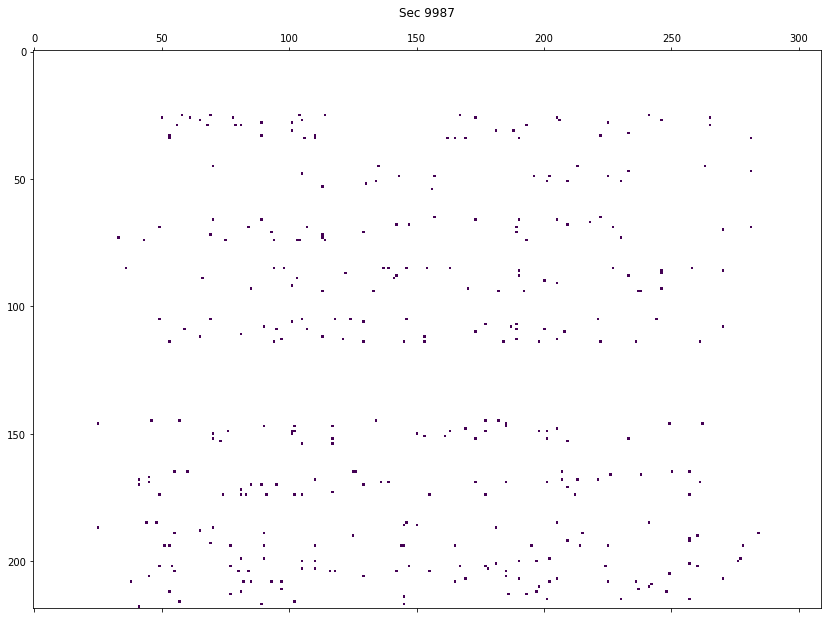

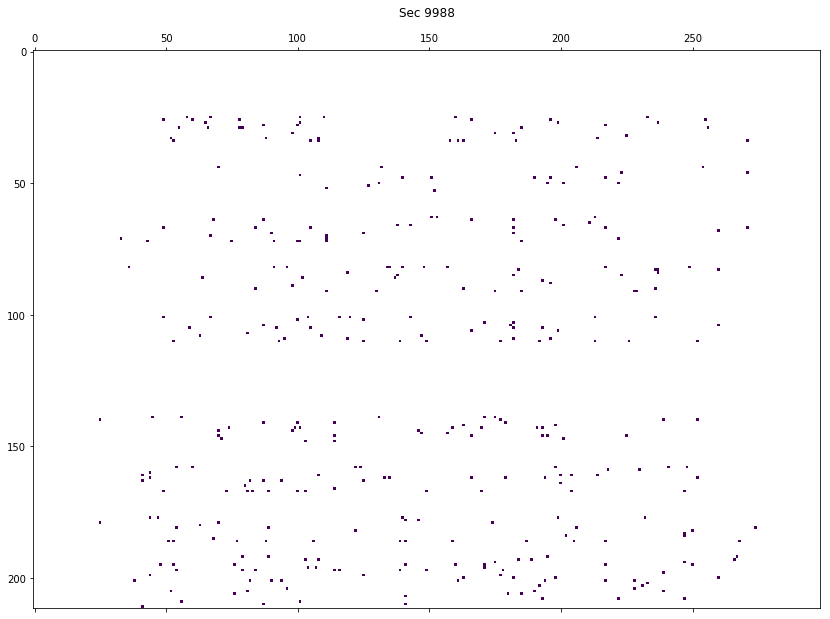

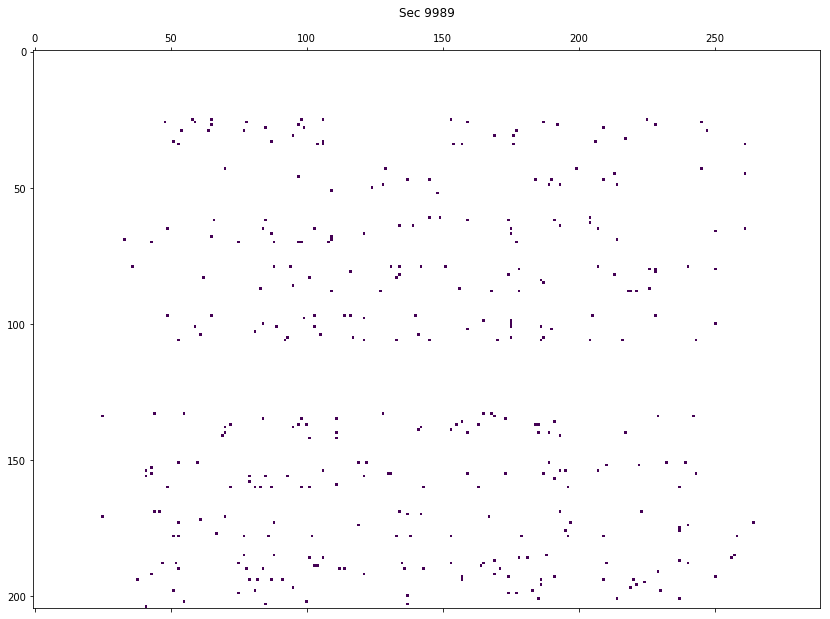

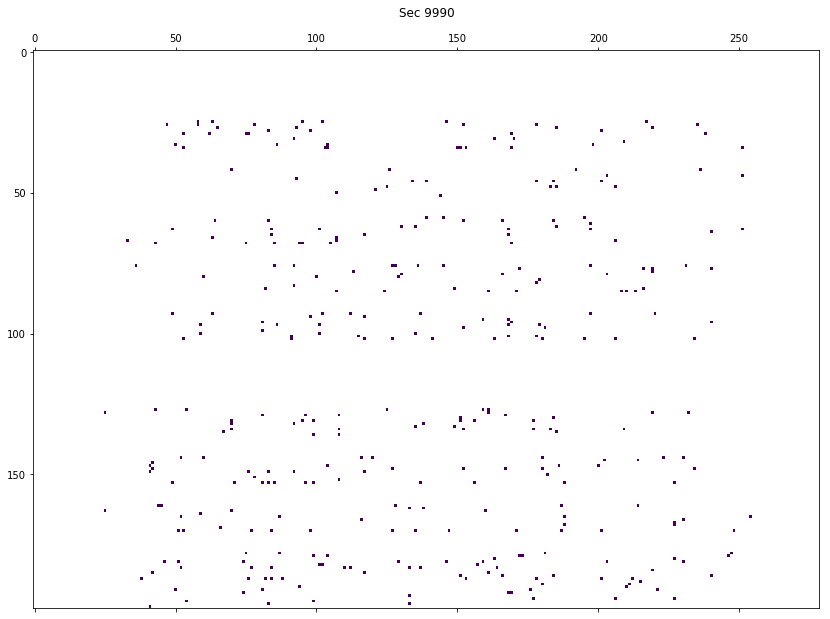

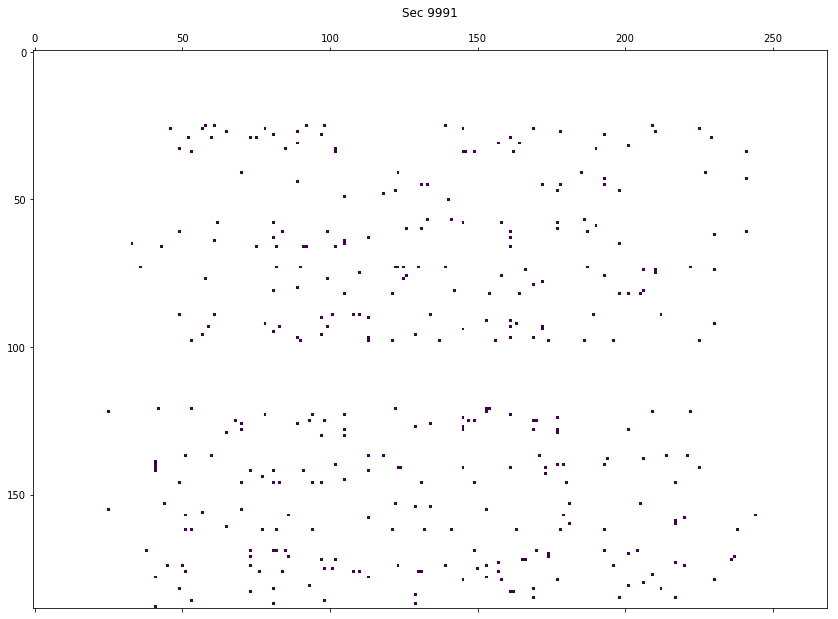

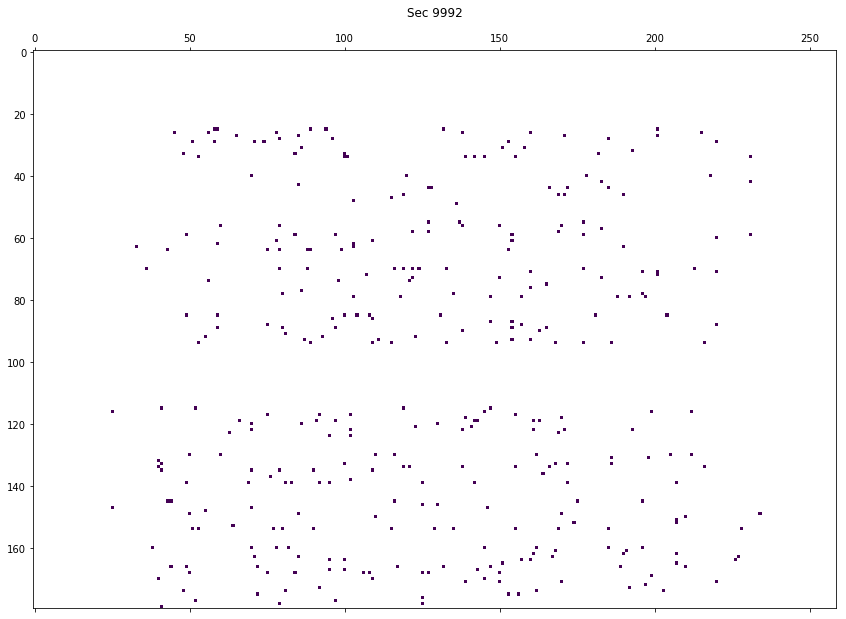

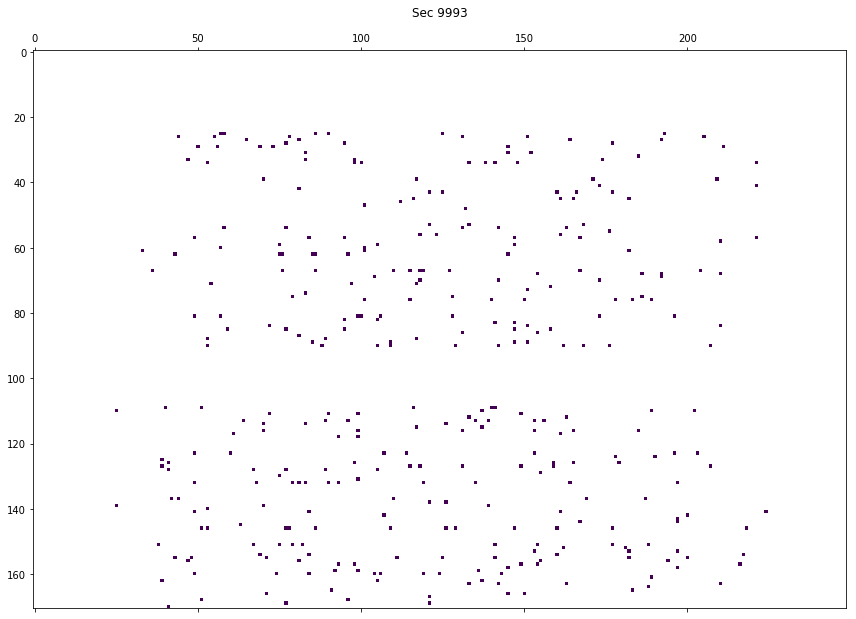

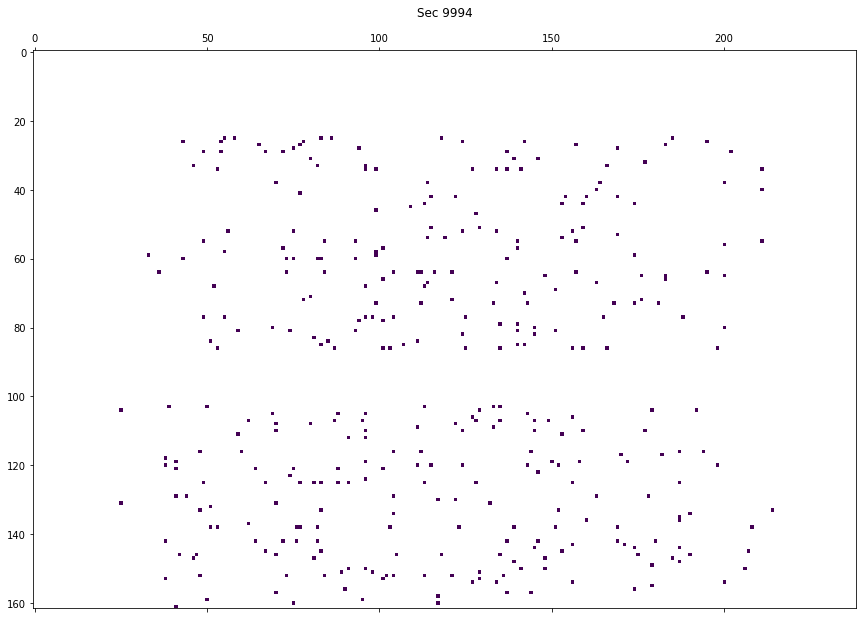

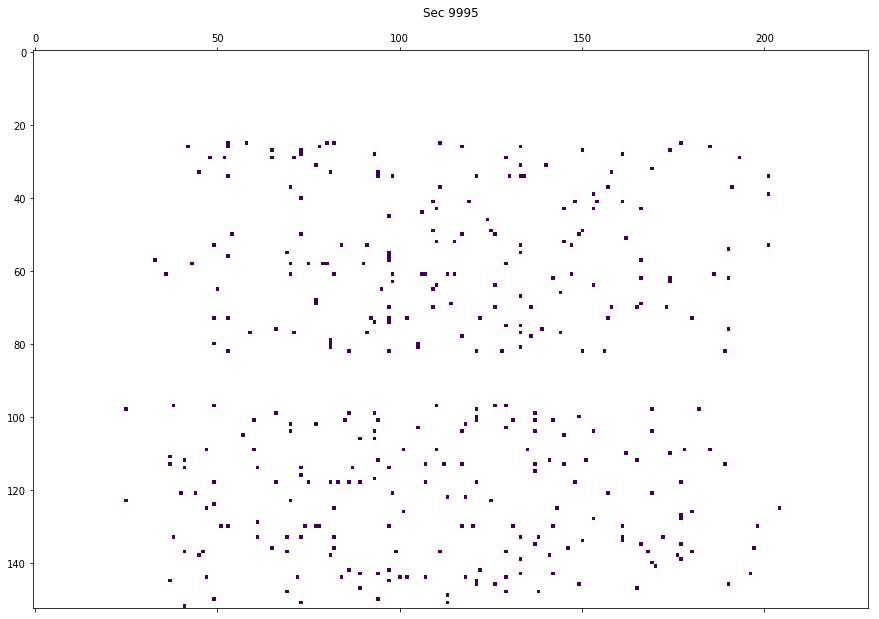

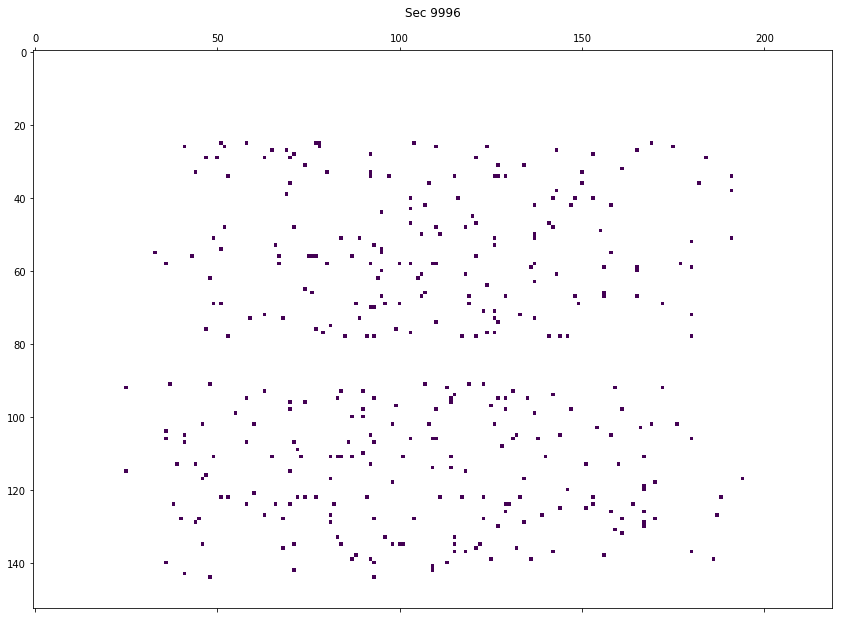

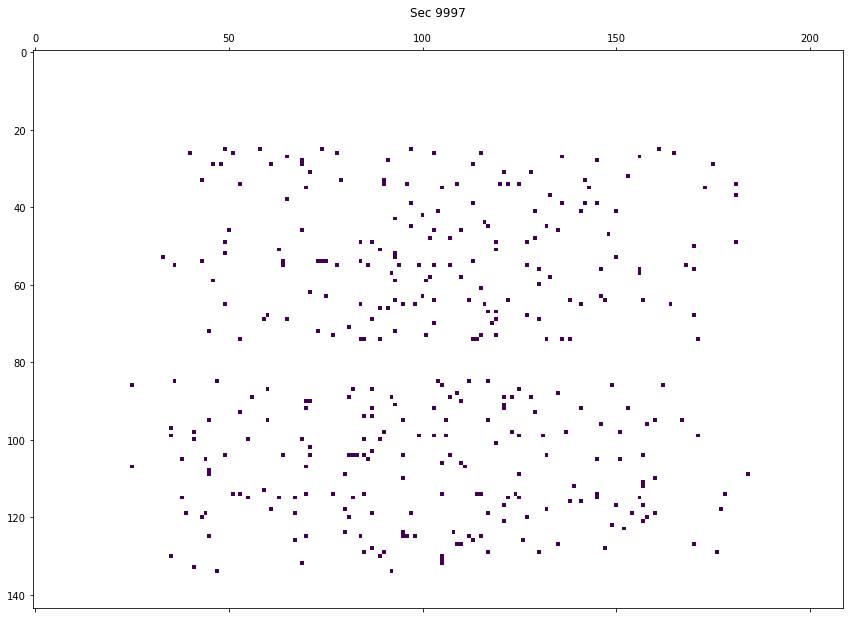

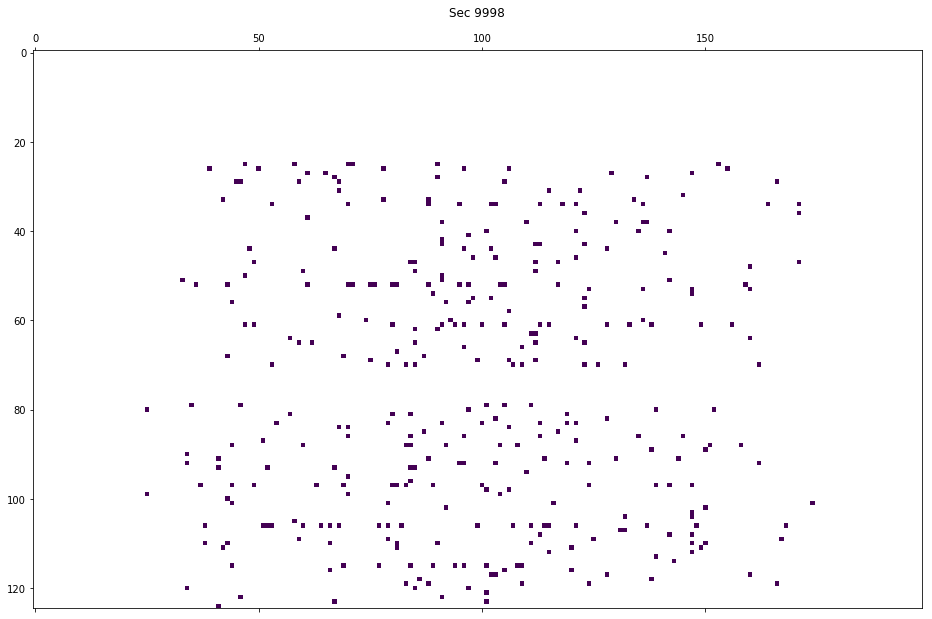

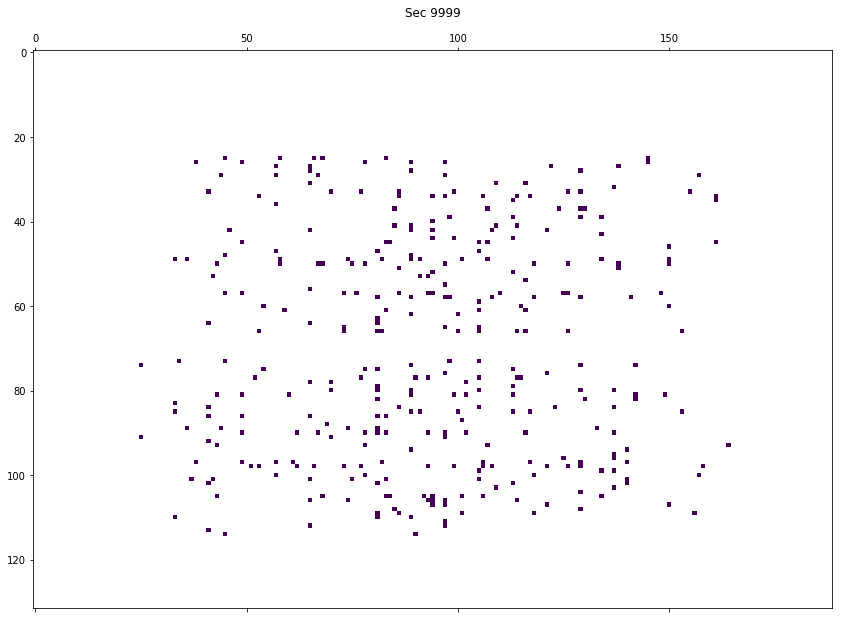

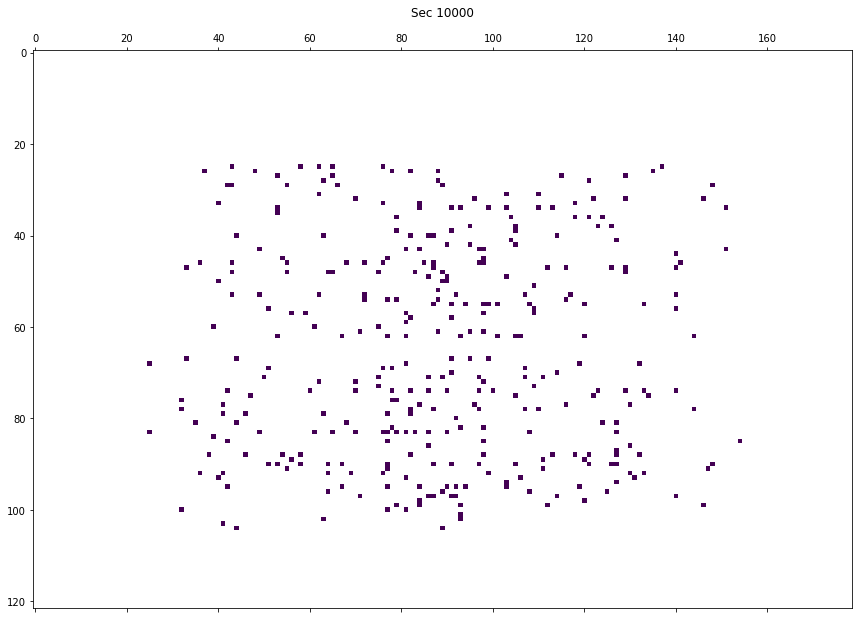

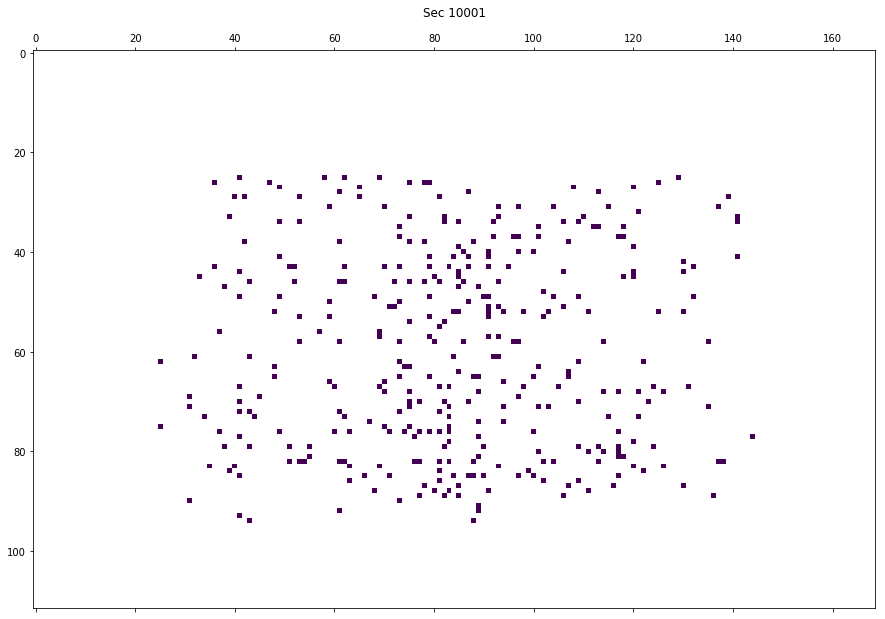

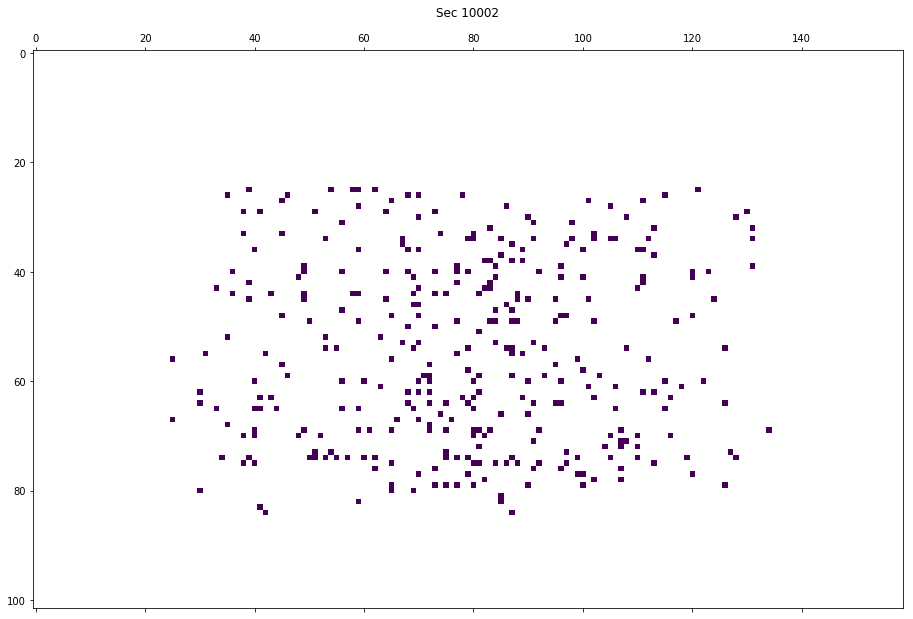

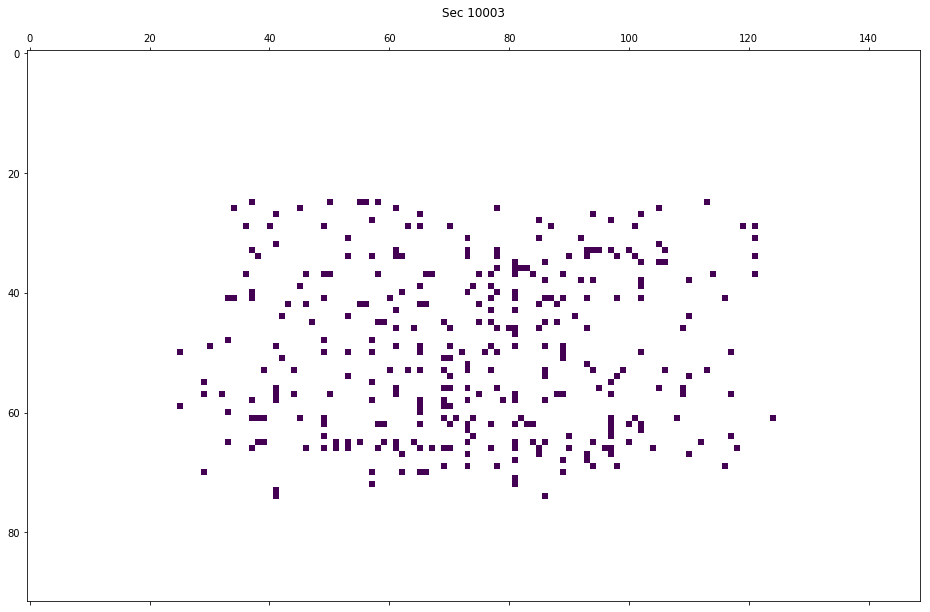

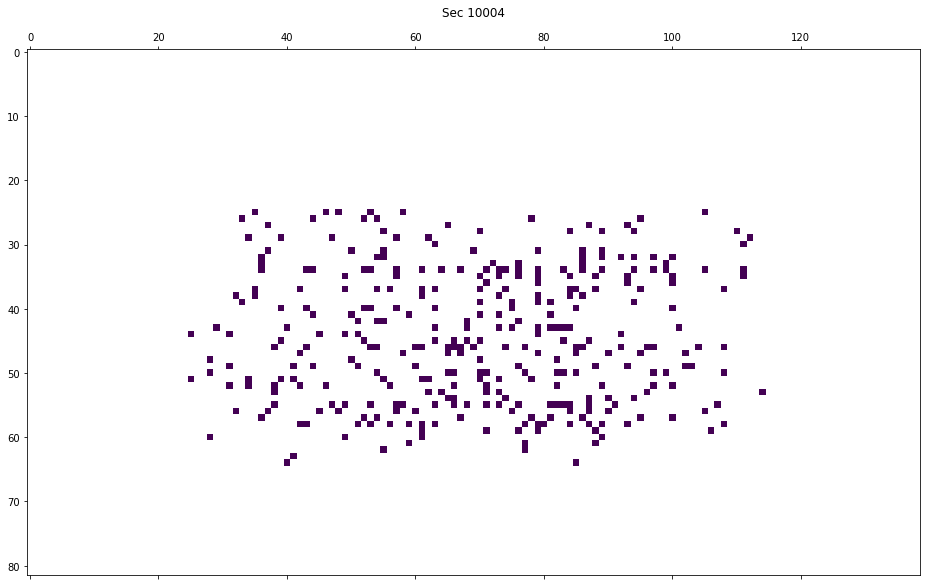

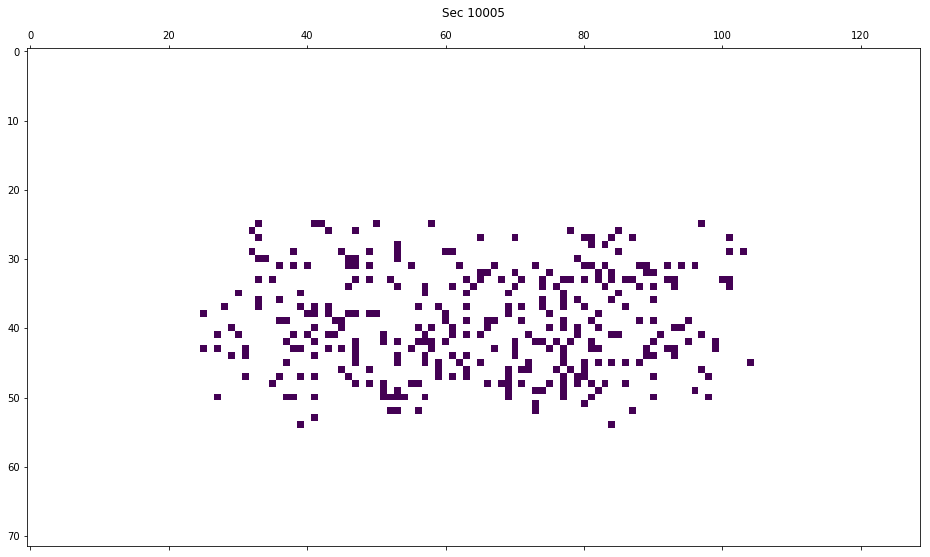

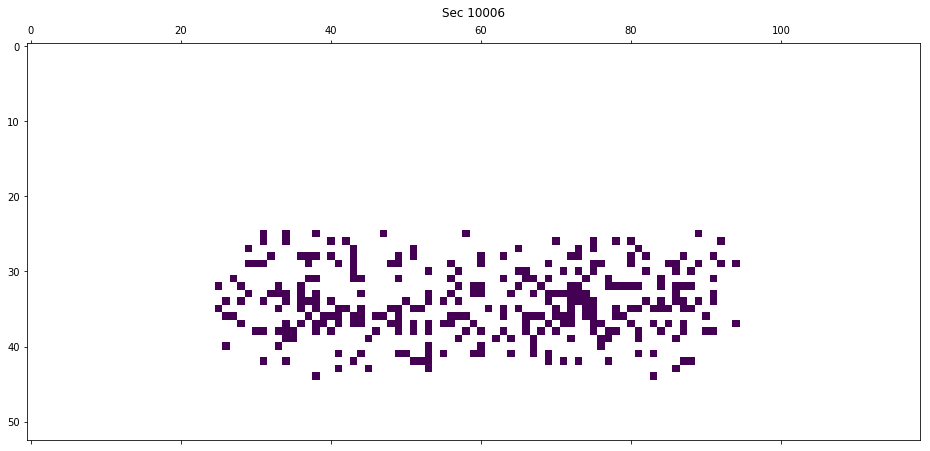

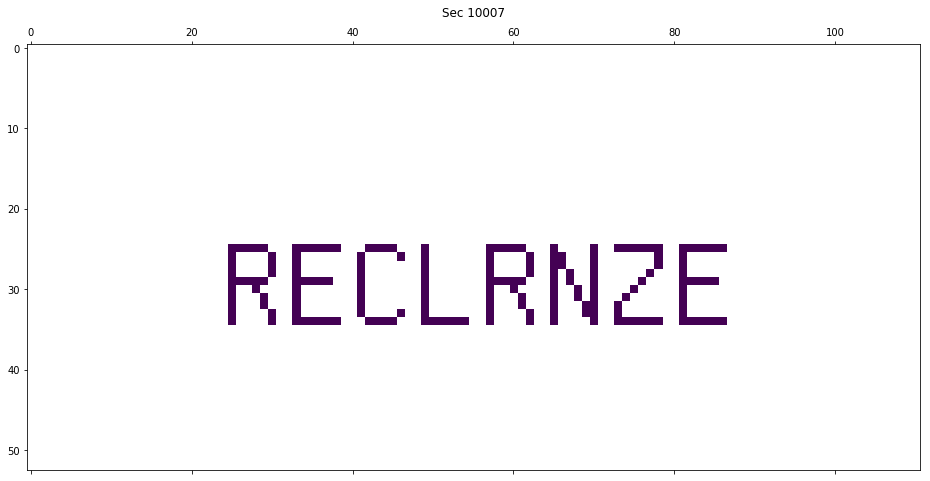

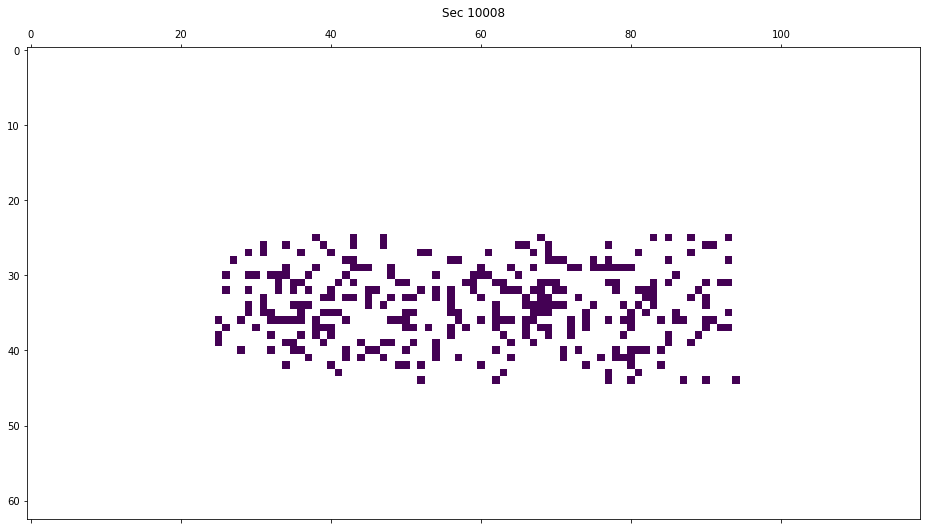

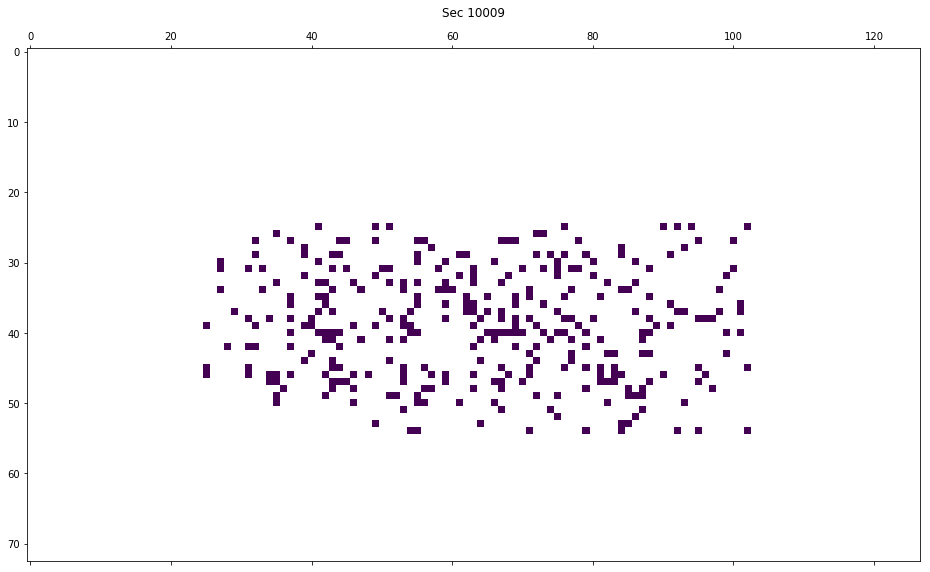

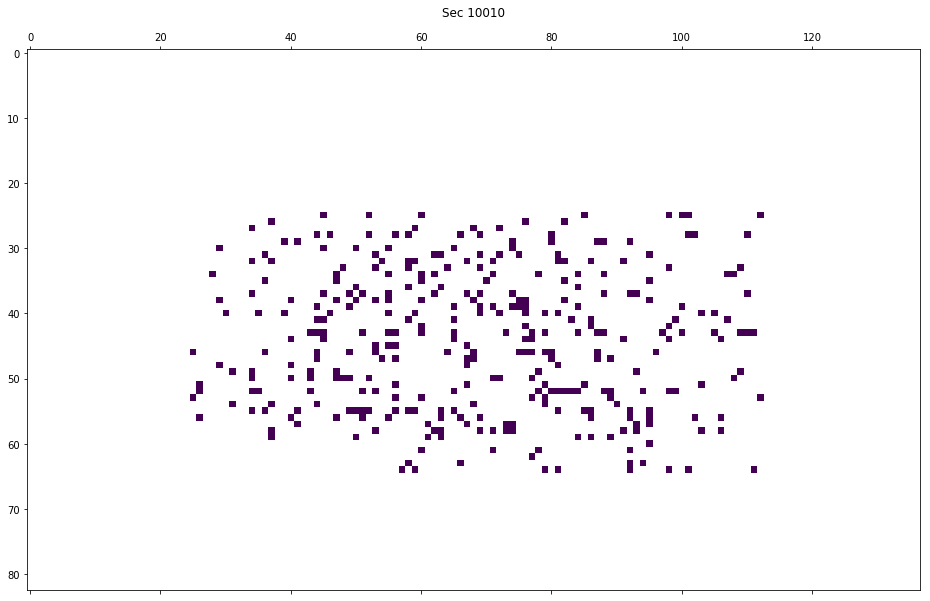

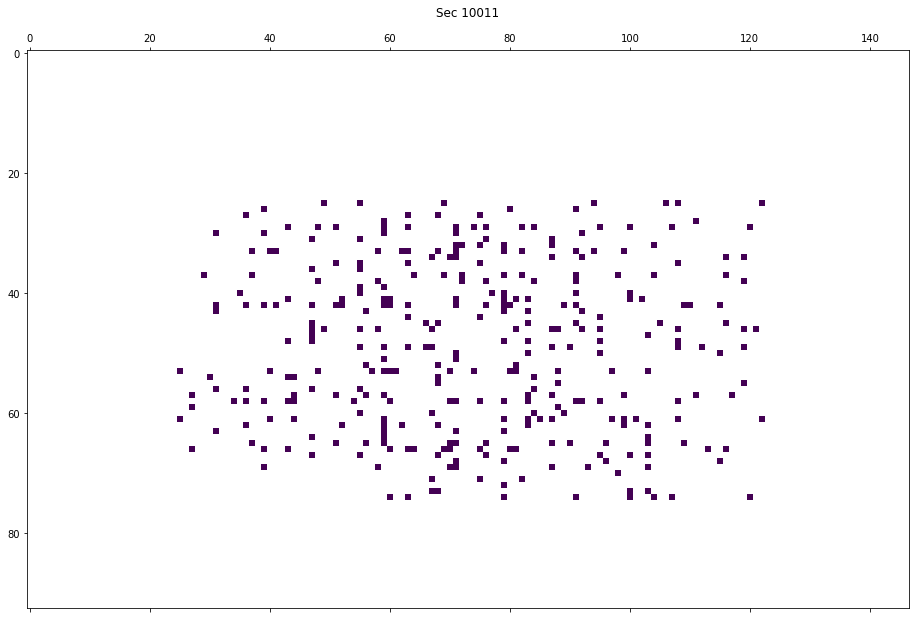

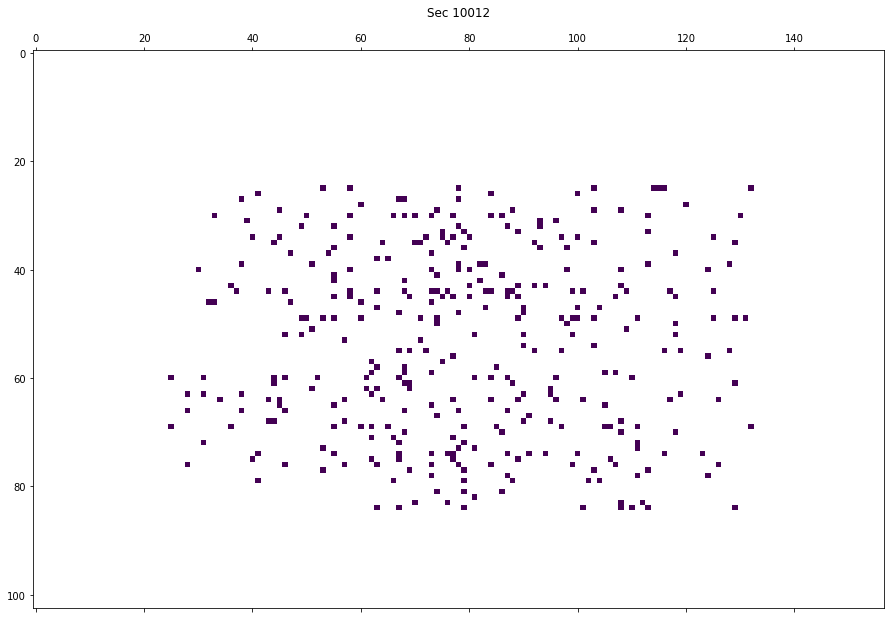

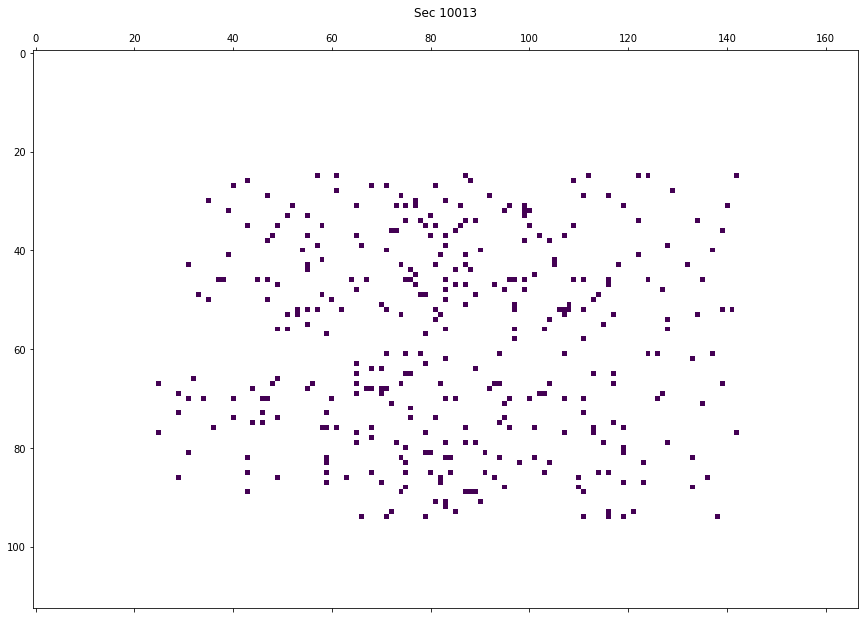

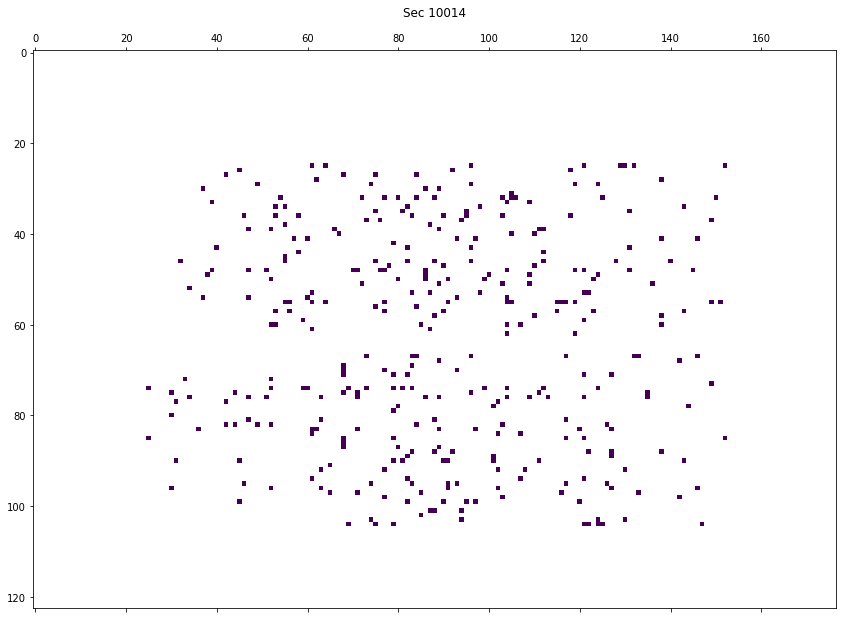

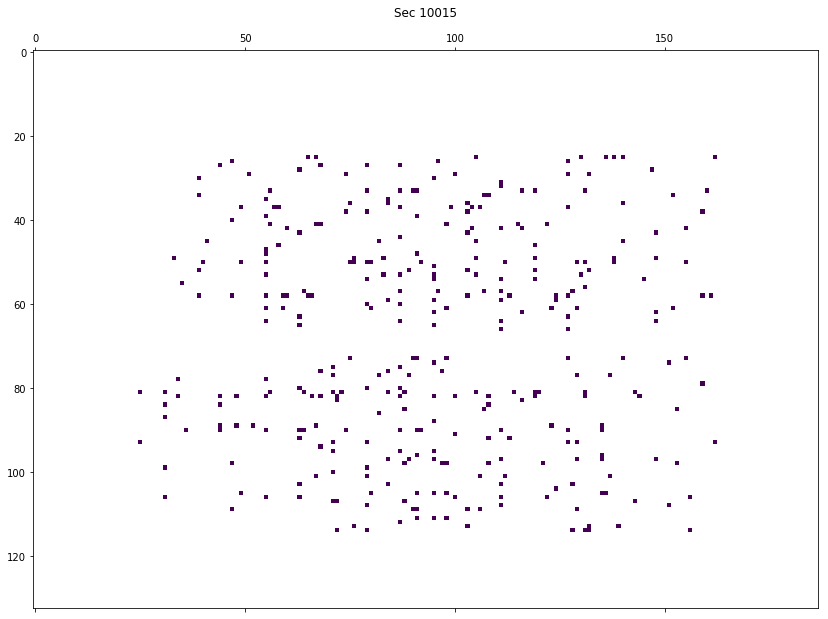

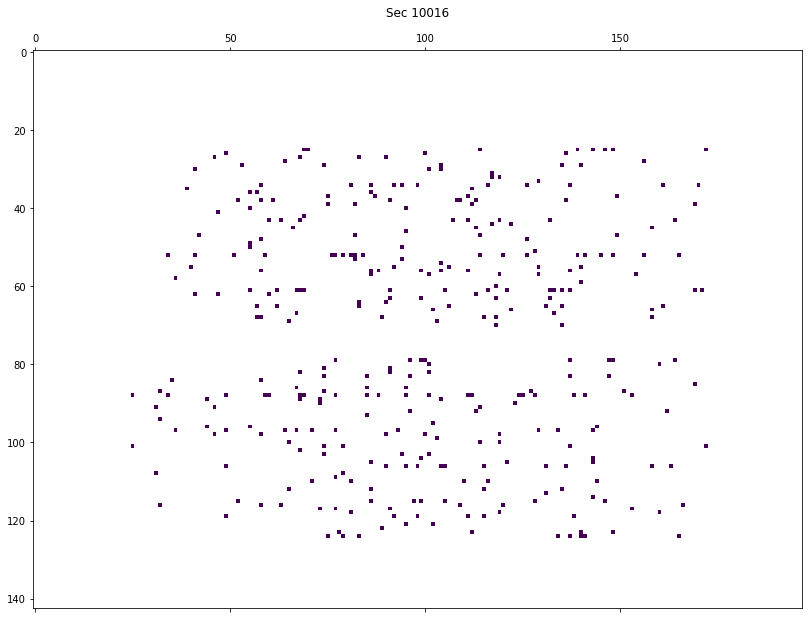

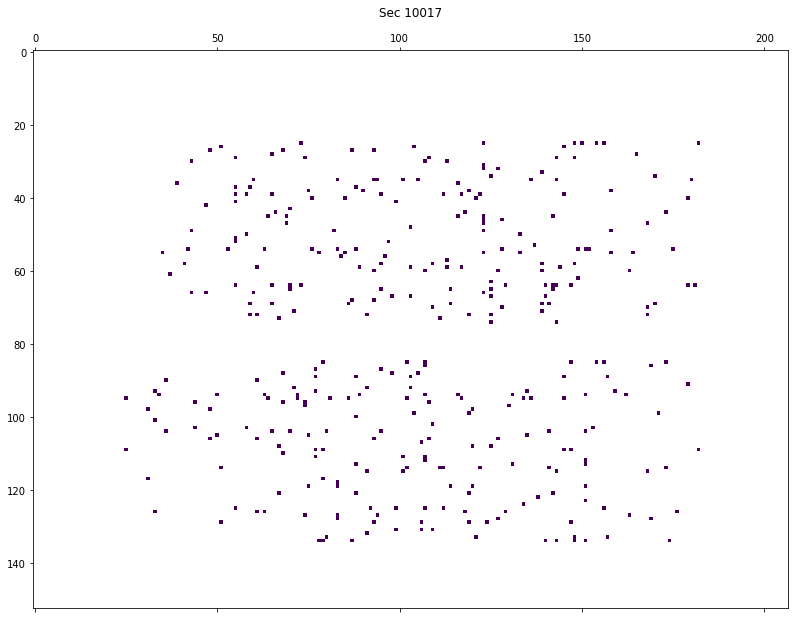

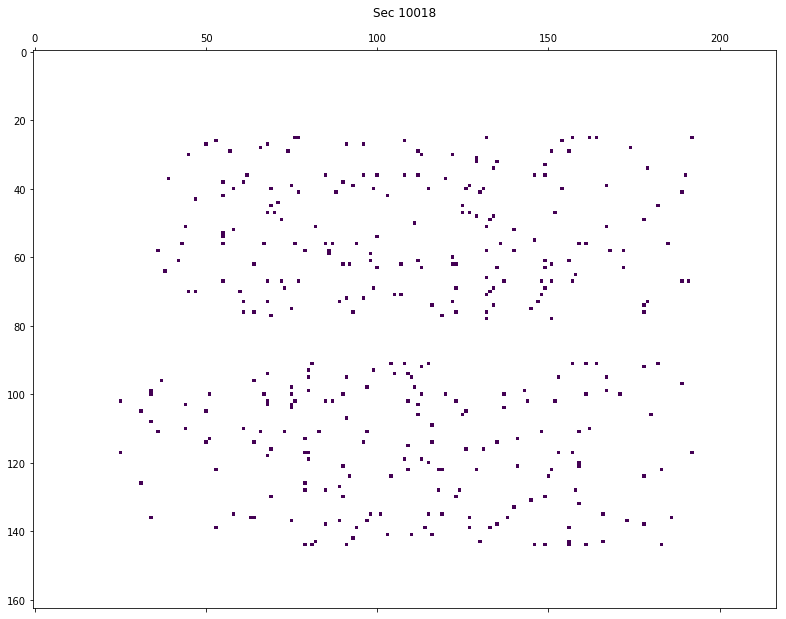

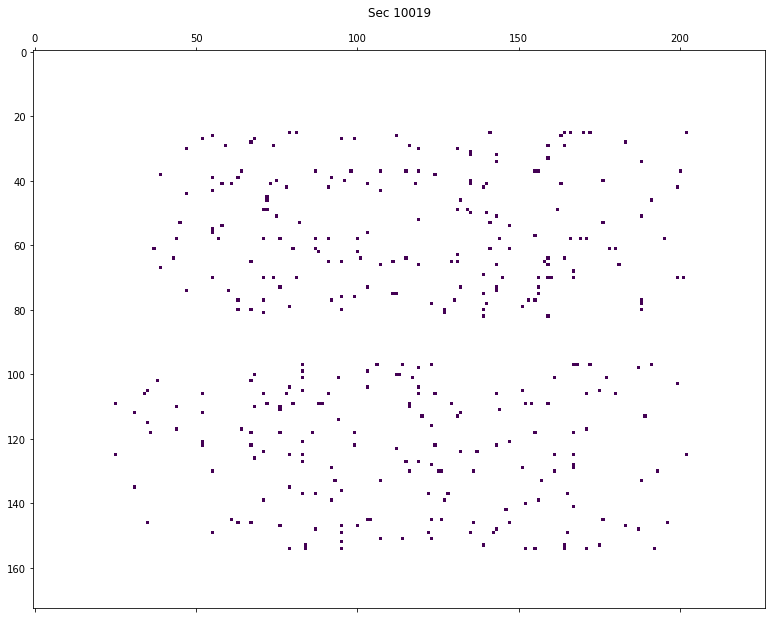

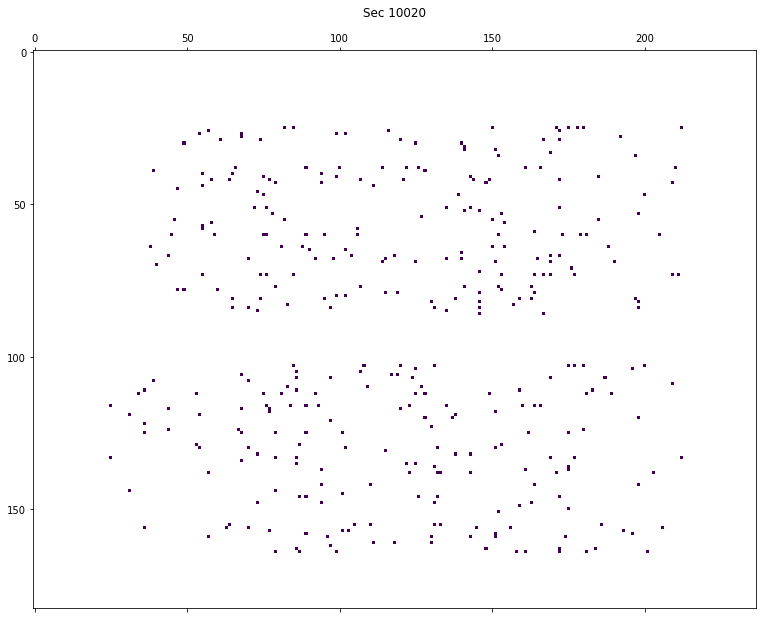

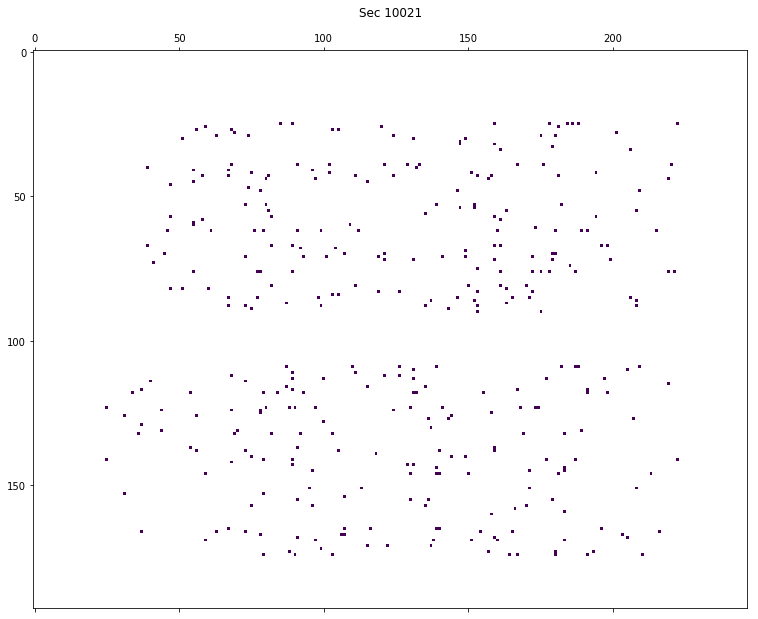

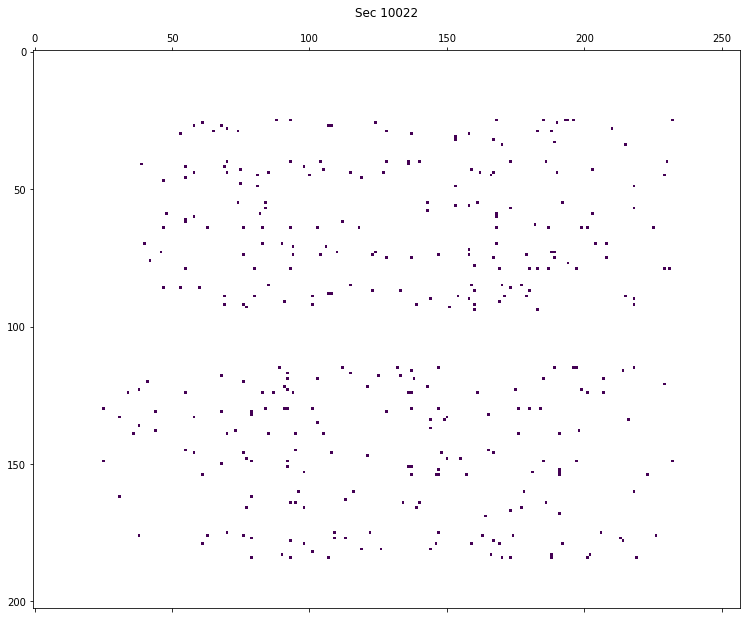

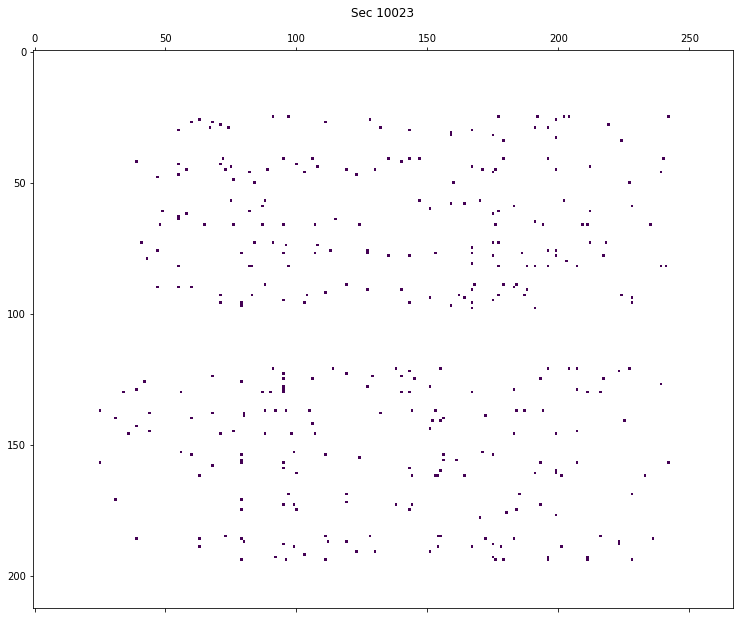

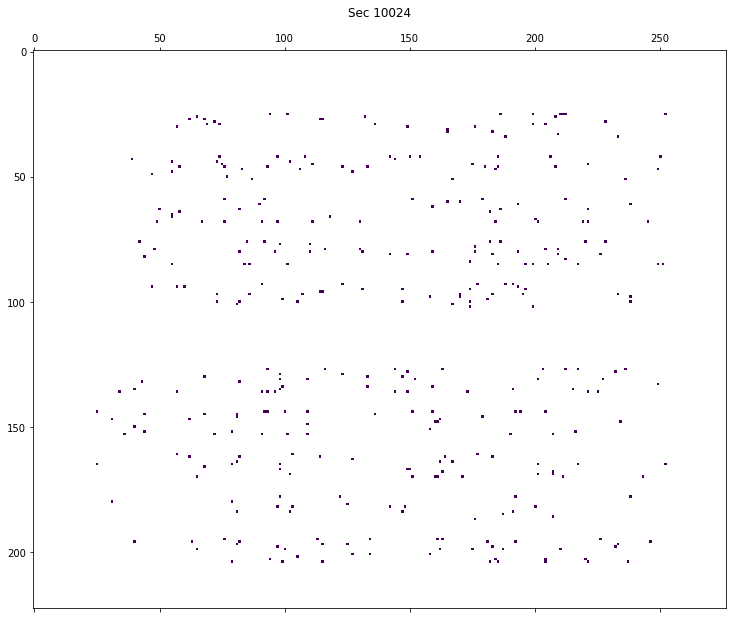

In [8]:
night_sky = NightSky([Star(*star) for star in coords])

for i in range(11000):
    if i > 9975 and i < 10025:
        current_sky = night_sky.paint_the_sky()
        plt.matshow(current_sky)
        plt.title(f'Sec {i}')
        plt.savefig(f'./images/sec_{i}.png')
        
    night_sky.increase_sec()
    
plt.show();

## RECLRNZE at sec 10007